In [515]:
import pandas as pd
import numpy as np
import pandas as pd

In [516]:
DATA_FILE = "20200807_user-db_cpu-load_02.json"
TARGET_DATA = {"containers": ["container_cpu_usage_seconds_total", "container_fs_io_current", "container_memory_working_set_bytes", "container_network_receive_bytes_total", "container_network_transmit_bytes_total"],
               "services": ["throughput", "latency"]}

In [517]:
raw_data = pd.read_json(DATA_FILE)
raw_data
#for s in raw_data["services"]["carts"]:
#    print(s["metric_name"])
#for c in raw_data["containers"]["carts"]:
#    print(c["metric_name"])

,containers,services
carts,"[{'container_name': 'carts', 'metric_name': 'c...","[{'service_name': 'carts', 'metric_name': 'thr..."
catalogue,"[{'container_name': 'catalogue', 'metric_name'...","[{'service_name': 'catalogue', 'metric_name': ..."
catalogue-db,"[{'container_name': 'catalogue-db', 'metric_na...",NaN
front-end,"[{'container_name': 'front-end', 'metric_name'...","[{'service_name': 'front-end', 'metric_name': ..."
orders,"[{'container_name': 'orders', 'metric_name': '...","[{'service_name': 'orders', 'metric_name': 'th..."
orders-db,"[{'container_name': 'orders-db', 'metric_name'...",NaN
payment,"[{'container_name': 'payment', 'metric_name': ...","[{'service_name': 'payment', 'metric_name': 't..."
queue-master,"[{'container_name': 'queue-master', 'metric_na...",NaN
rabbitmq,"[{'container_name': 'rabbitmq', 'metric_name':...",NaN
shipping,"[{'container_name': 'shipping', 'metric_name':...","[{'service_name': 'shipping', 'metric_name': '..."


In [518]:
# Prepare data matrix
data_df = pd.DataFrame()
for target in TARGET_DATA:
    for t in raw_data[target].dropna():
        for metric in t:
            if metric["metric_name"] in TARGET_DATA[target]:
                column_name = "{}-{}-{}".format(target[0], metric["{}_name".format(target[:-1])], metric["metric_name"].replace("container", ""))
                data_df[column_name] = np.array(metric["values"], dtype=np.float64)[:, 1]
data_df

,c-carts-_memory_working_set_bytes,c-carts-_fs_io_current,c-carts-_cpu_usage_seconds_total,c-catalogue-_memory_working_set_bytes,c-catalogue-_fs_io_current,c-catalogue-_cpu_usage_seconds_total,c-catalogue-db-_memory_working_set_bytes,c-catalogue-db-_fs_io_current,c-catalogue-db-_cpu_usage_seconds_total,c-front-end-_memory_working_set_bytes,...,s-front-end-throughput,s-front-end-latency,s-orders-throughput,s-orders-latency,s-payment-throughput,s-payment-latency,s-shipping-throughput,s-shipping-latency,s-user-throughput,s-user-latency
0,295460864.0,0.0,0.063995,10997760.0,0.0,0.014953,212324352.0,0.0,0.011705,123871232.0,...,67.244444,0.057726,6.244444,0.018097,7.044444,0.000231,6.266667,0.000626,46.733333,0.005930
1,295862272.0,0.0,0.069885,10997760.0,0.0,0.015208,212426752.0,0.0,0.010085,124076032.0,...,69.644444,0.058566,6.333333,0.020025,7.288889,0.000250,6.444301,0.000615,48.333333,0.005505
2,295862272.0,0.0,0.073497,10997760.0,0.0,0.015272,212324352.0,0.0,0.012003,131764224.0,...,70.866667,0.058216,6.755556,0.020212,7.333333,0.000253,6.688889,0.000613,52.244444,0.004994
3,295862272.0,0.0,0.052025,10997760.0,0.0,0.017152,212344832.0,0.0,0.013195,132505600.0,...,80.311111,0.052784,7.400000,0.018607,8.555556,0.000238,7.533333,0.000612,60.111111,0.004145
4,295694336.0,0.0,0.090909,11001856.0,0.0,0.018619,212463616.0,0.0,0.014956,161374208.0,...,89.311111,0.046364,8.111111,0.016714,9.466667,0.000238,8.266850,0.000637,64.955556,0.003605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,295890944.0,0.0,0.064207,11108352.0,0.0,0.012987,212717568.0,0.0,0.011001,116146176.0,...,64.088889,0.085845,6.243057,0.053169,6.850991,0.000253,6.311111,0.000636,44.888889,0.025687
237,295890944.0,0.0,0.038934,11108352.0,0.0,0.012911,212574208.0,0.0,0.009138,117612544.0,...,63.444444,0.088293,6.066667,0.057535,6.755856,0.000230,6.088618,0.000624,44.022222,0.025879
238,295890944.0,0.0,0.060631,11108352.0,0.0,0.012884,212586496.0,0.0,0.010925,119349248.0,...,63.288889,0.087193,6.266667,0.056424,6.844597,0.000230,6.378203,0.000634,44.022222,0.026522
239,295890944.0,0.0,0.061362,11108352.0,0.0,0.011447,212615168.0,0.0,0.010871,115634176.0,...,62.088889,0.088281,6.090242,0.050838,6.688889,0.000230,6.000000,0.000672,44.422222,0.026266


In [519]:
labels = {}
for i in range(len(data_df.columns)):
    labels[i] = data_df.columns[i]
labels

{0: 'c-carts-_memory_working_set_bytes',
 1: 'c-carts-_fs_io_current',
 2: 'c-carts-_cpu_usage_seconds_total',
 3: 'c-catalogue-_memory_working_set_bytes',
 4: 'c-catalogue-_fs_io_current',
 5: 'c-catalogue-_cpu_usage_seconds_total',
 6: 'c-catalogue-db-_memory_working_set_bytes',
 7: 'c-catalogue-db-_fs_io_current',
 8: 'c-catalogue-db-_cpu_usage_seconds_total',
 9: 'c-front-end-_memory_working_set_bytes',
 10: 'c-front-end-_fs_io_current',
 11: 'c-front-end-_cpu_usage_seconds_total',
 12: 'c-orders-_memory_working_set_bytes',
 13: 'c-orders-_fs_io_current',
 14: 'c-orders-_cpu_usage_seconds_total',
 15: 'c-orders-db-_memory_working_set_bytes',
 16: 'c-orders-db-_fs_io_current',
 17: 'c-orders-db-_cpu_usage_seconds_total',
 18: 'c-payment-_memory_working_set_bytes',
 19: 'c-payment-_fs_io_current',
 20: 'c-payment-_cpu_usage_seconds_total',
 21: 'c-queue-master-_memory_working_set_bytes',
 22: 'c-queue-master-_fs_io_current',
 23: 'c-queue-master-_cpu_usage_seconds_total',
 24: 'c-rab

## Fisher-Z検定

In [531]:
dm = data_df.values
dm.shape

(241, 50)

In [532]:
import sys 
sys.path.append("../") 
from citestfz.ci_tests import ci_test_gauss
cm = np.corrcoef(dm.T)

(G, sep_set) = pcalg.estimate_skeleton(indep_test_func=ci_test_gauss,
                                 data_matrix=dm,
                                 alpha=0.01,
                                 corr_matrix=cm)
G = pcalg.estimate_cpdag(skel_graph=G, sep_set=sep_set)

In [522]:
remove_nodes = list(G.nodes)
for edge in G.edges():
    for n in edge:
        try:
            remove_nodes.remove(n)
        except ValueError:
            pass
print(remove_nodes)
G.remove_nodes_from(remove_nodes)

[1, 2, 4, 7, 8, 10, 11, 12, 13, 16, 17, 19, 20, 22, 25, 28, 29, 31, 32, 34]


In [523]:
G = nx.relabel_nodes(G, labels)

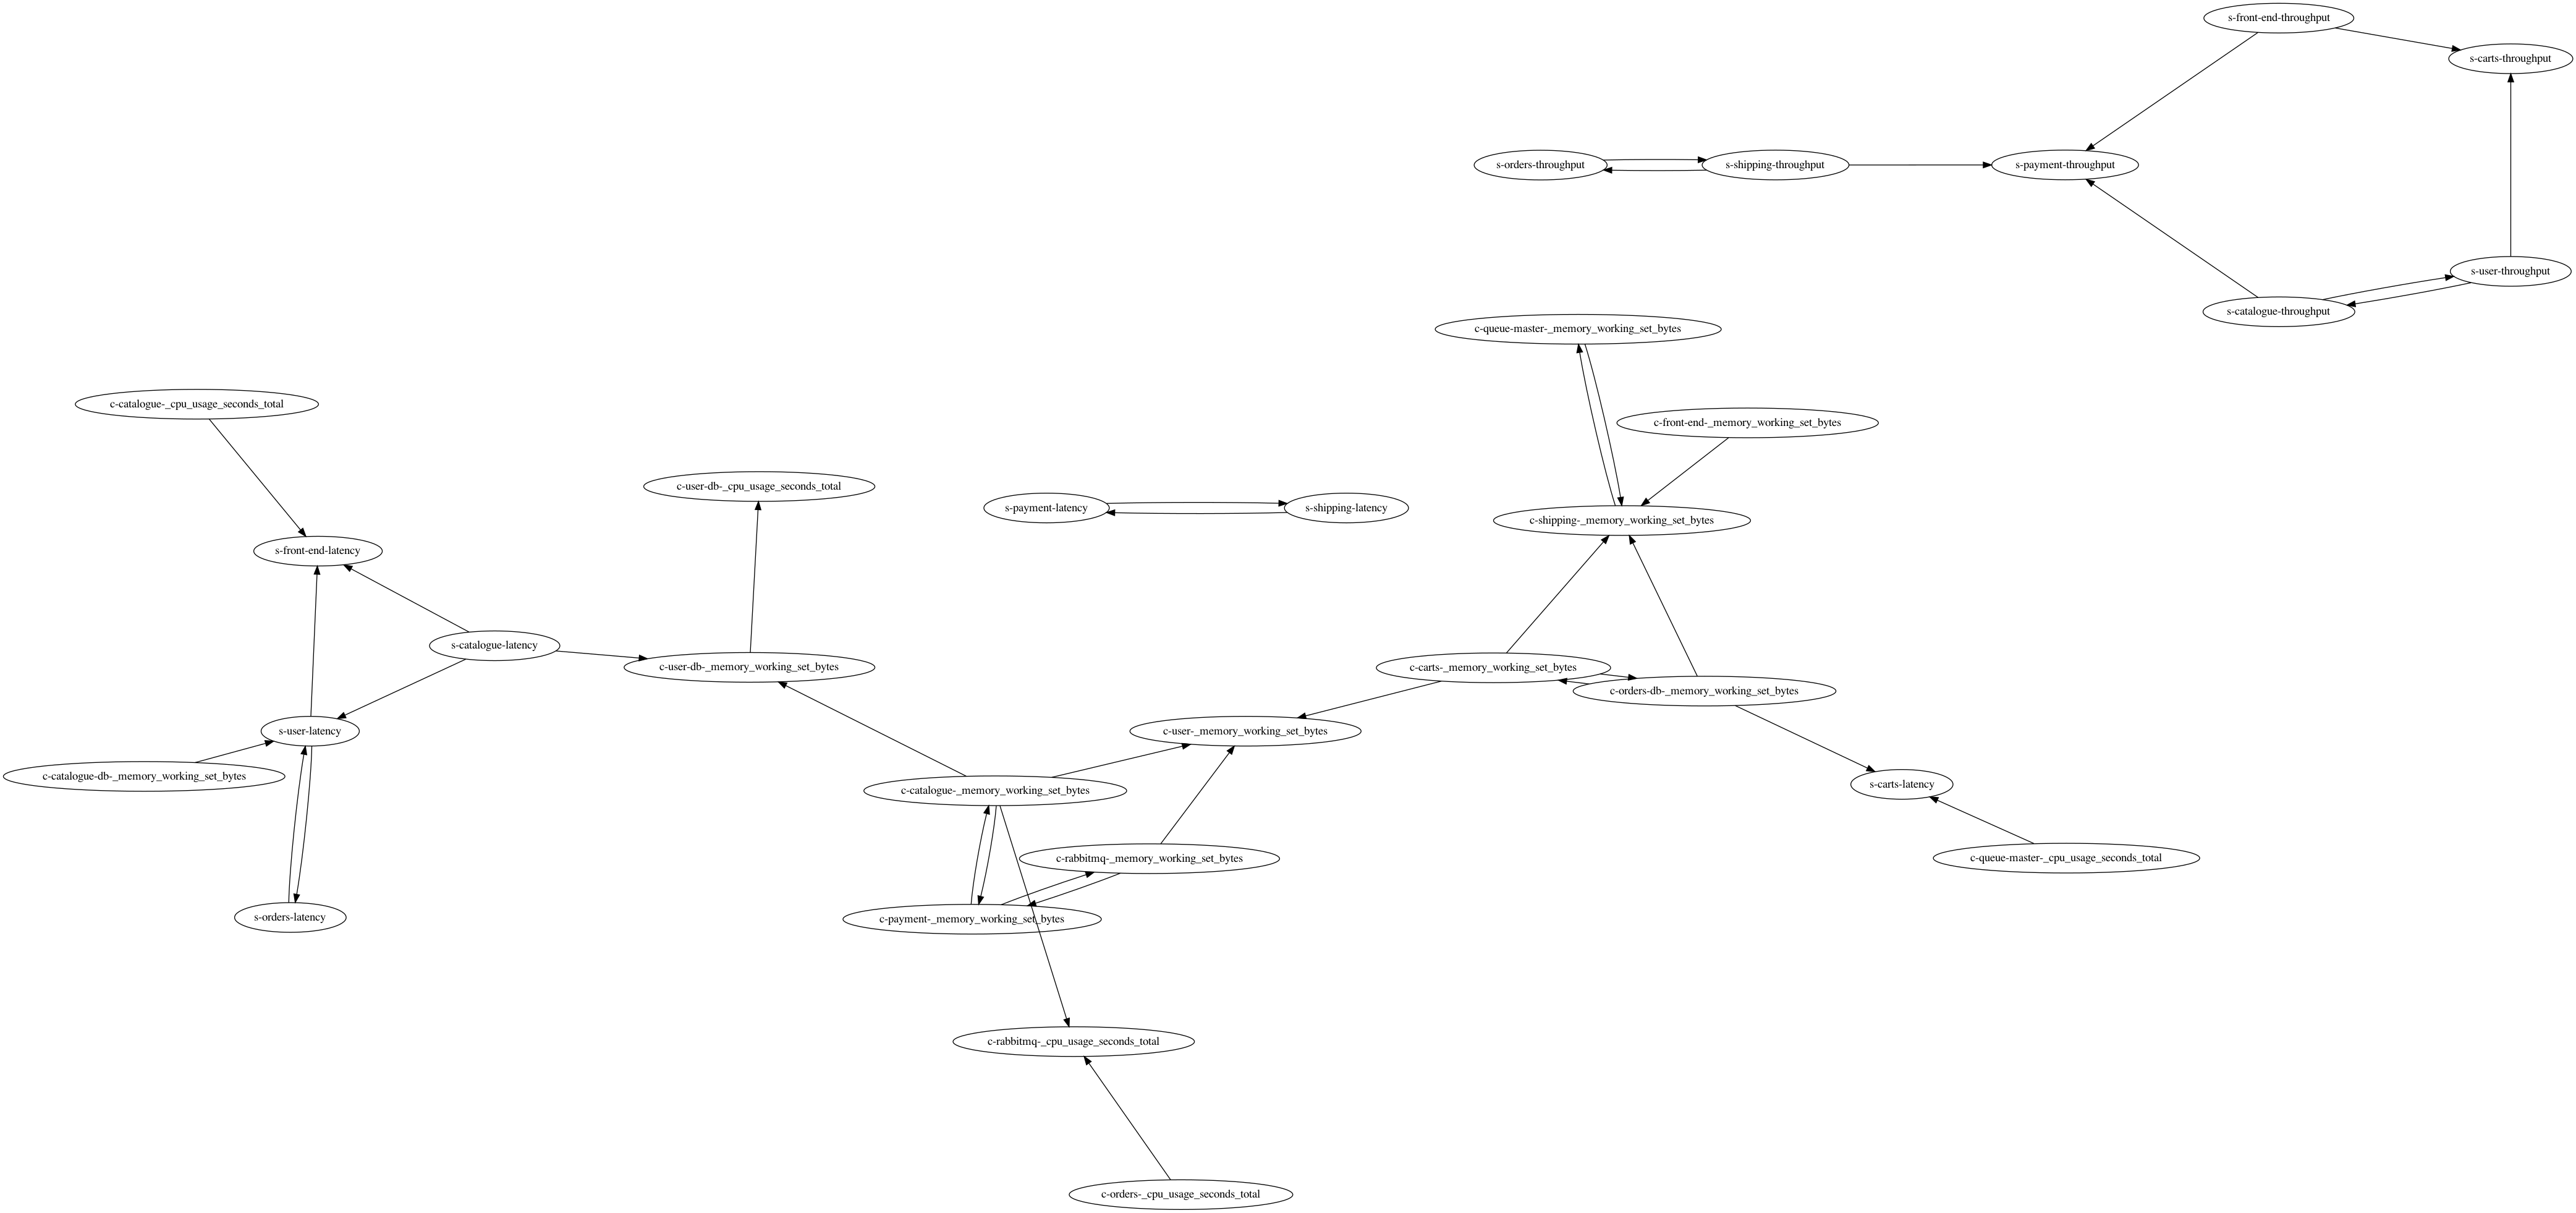

In [524]:
from IPython.display import Image, SVG, display

# prog=[‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’] 
agraph = nx.nx_agraph.to_agraph(G).draw(prog='sfdp', format='png')
Image(agraph)

## G square test

In [279]:
# Determine the number of categories by Sturges' rule
data_size = len(data_df)
n_bins = int(np.log2(data_size) + 1)
print("Number of bins: {}".format(n_bins))

Number of bins: 8


In [280]:
disc_data_df = pd.DataFrame()
for col in data_df.columns:
    disc_data_df[col] = pd.cut(data_df[col], n_bins, labels=np.arange(0, n_bins))
disc_data_df.head()

,containers-carts-container_memory_working_set_bytes,containers-carts-container_fs_io_current,containers-carts-container_cpu_usage_seconds_total,containers-catalogue-container_memory_working_set_bytes,containers-catalogue-container_fs_io_current,containers-catalogue-container_cpu_usage_seconds_total,containers-catalogue-db-container_memory_working_set_bytes,containers-catalogue-db-container_fs_io_current,containers-catalogue-db-container_cpu_usage_seconds_total,containers-front-end-container_memory_working_set_bytes,...,services-front-end-throughput,services-front-end-latency,services-orders-throughput,services-orders-latency,services-payment-throughput,services-payment-latency,services-shipping-throughput,services-shipping-latency,services-user-throughput,services-user-latency
0,0,3,3,0,3,3,0,3,4,1,...,1,2,0,0,0,3,0,3,0,0
1,7,3,4,0,3,3,2,3,3,1,...,1,3,0,1,1,5,1,2,1,0
2,7,3,4,0,3,3,0,3,4,1,...,1,3,1,1,1,6,1,2,2,0
3,7,3,1,0,3,5,0,3,5,2,...,3,2,3,0,3,4,3,2,4,0
4,4,3,6,0,3,6,2,3,6,5,...,5,1,4,0,5,4,5,4,6,0


In [281]:
disc_data_df.values.shape

(241, 50)

In [283]:
import pcalg
import networkx as nx
import numpy as np
from gsq.ci_tests import ci_test_dis

(g, sep_set) = pcalg.estimate_skeleton(indep_test_func=ci_test_dis,
                                 data_matrix=disc_data_df.values,
                                 alpha=0.01)
                                 #levels=[3,2,3,4,2])
g = pcalg.estimate_cpdag(skel_graph=g, sep_set=sep_set)
nx.draw(g, with_labels=True)

IndentationError: unexpected indent (<ipython-input-283-de512d28de16>, line 7)

In [513]:
#nx.draw_networkx(G, with_labels=True)
#nx.nx_agraph.view_pygraphviz(G, prog='fdp')
#from IPython.display import SVG, display
#svg = SVG(nx.nx_agraph.to_agraph(G).draw(prog='sfdp', format='svg'))
#display(svg)

## 事前知識を入れる

In [84]:
import pcalg
import networkx as nx
from gsq.ci_tests import ci_test_dis
from gsq.gsq_testdata import dis_data

dm = np.array(dis_data).reshape((10000, 5))
node_ids = range(dm.shape[1])
node_ids

range(0, 5)

In [85]:
from itertools import combinations

init_g = nx.Graph()
init_g.add_nodes_from(node_ids)
for (i, j) in combinations(node_ids, 2):
    init_g.add_edge(i, j)

no_paths=[[4, 1], [1, 2]]
for no_path in no_paths:
    init_g.remove_edge(no_path[0], no_path[1])
# nx.nx_agraph.view_pygraphviz(g, prog='fdp')

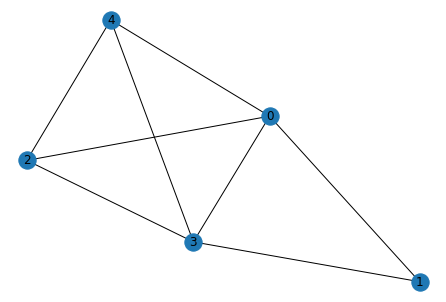

In [86]:
nx.draw(init_g, with_labels=True)

In [88]:
(g, sep_set) = pcalg.estimate_skeleton(indep_test_func=ci_test_dis,
                                 data_matrix=dm,
                                 alpha=0.01,
                                 levels=[3,2,3,4,2],
                                 init_graph=init_g)
g = pcalg.estimate_cpdag(skel_graph=g, sep_set=sep_set)
g_answer = nx.DiGraph()
g_answer.add_nodes_from([0, 1, 2, 3, 4])
g_answer.add_edges_from([(0, 2), (1, 2), (1, 3), (4, 3)])
print('Edges are:', g.edges(), end='')
if nx.is_isomorphic(g, g_answer):
    print(' => GOOD')
else:
    print(' => WRONG')
    print('True edges should be:', g_answer.edges())

Edges are: [(0, 2), (1, 3), (2, 0), (3, 1), (3, 4), (4, 3)] => WRONG
True edges should be: [(0, 2), (1, 2), (1, 3), (4, 3)]


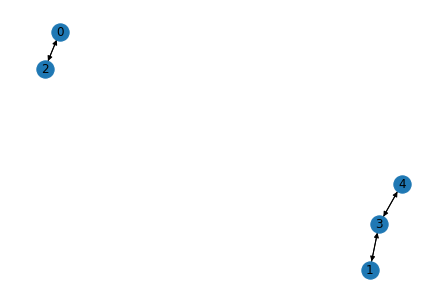

In [89]:
nx.draw(g, with_labels=True)